# Credit score Classification Portfolio

In this project we will build a machine learning model to predict credit score based on different client info.

In [85]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import pickle

## Brief look

In [2]:
df = pd.read_csv("train.csv")
df.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,5634,3392,1,Aaron Maashoh,23.0,821000265.0,Scientist,19114.12,1824.843333,3.0,...,Good,809.98,26.822620,265.0,No,49.574949,21.46538,High_spent_Small_value_payments,312.494089,Good
1,5635,3392,2,Aaron Maashoh,23.0,821000265.0,Scientist,19114.12,1824.843333,3.0,...,Good,809.98,31.944960,266.0,No,49.574949,21.46538,Low_spent_Large_value_payments,284.629162,Good
2,5636,3392,3,Aaron Maashoh,23.0,821000265.0,Scientist,19114.12,1824.843333,3.0,...,Good,809.98,28.609352,267.0,No,49.574949,21.46538,Low_spent_Medium_value_payments,331.209863,Good
3,5637,3392,4,Aaron Maashoh,23.0,821000265.0,Scientist,19114.12,1824.843333,3.0,...,Good,809.98,31.377862,268.0,No,49.574949,21.46538,Low_spent_Small_value_payments,223.451310,Good
4,5638,3392,5,Aaron Maashoh,23.0,821000265.0,Scientist,19114.12,1824.843333,3.0,...,Good,809.98,24.797347,269.0,No,49.574949,21.46538,High_spent_Medium_value_payments,341.489231,Good


There are 28 columns but some of them consists personal info or client identification number and we don't need this informations. On this stage we will drop "ID", "Customer_ID", "Name" and "SSN" which represent social security number of a client.

In [3]:
df.drop(columns=["ID", "Customer_ID", "Name", "SSN"], inplace=True)

Quick check if there are any duplicates.

In [4]:
df.duplicated().sum()

0

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 24 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Month                     100000 non-null  int64  
 1   Age                       100000 non-null  float64
 2   Occupation                100000 non-null  object 
 3   Annual_Income             100000 non-null  float64
 4   Monthly_Inhand_Salary     100000 non-null  float64
 5   Num_Bank_Accounts         100000 non-null  float64
 6   Num_Credit_Card           100000 non-null  float64
 7   Interest_Rate             100000 non-null  float64
 8   Num_of_Loan               100000 non-null  float64
 9   Type_of_Loan              100000 non-null  object 
 10  Delay_from_due_date       100000 non-null  float64
 11  Num_of_Delayed_Payment    100000 non-null  float64
 12  Changed_Credit_Limit      100000 non-null  float64
 13  Num_Credit_Inquiries      100000 non-null  fl

The good information is that we don't have any missing values. We can spot that some columns like "Age" or ones representing quantity have float type where they should have int type. Let's fix it now.

In [6]:
for col in ["Age", "Num_Bank_Accounts", "Num_Credit_Card", "Interest_Rate", "Num_of_Loan", "Delay_from_due_date", "Num_of_Delayed_Payment", "Num_Credit_Inquiries", "Credit_History_Age"]:
    df[col] = df[col].astype("int")

In [7]:
df.describe()

,Month,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,4.500000,33.316340,50505.123449,4197.270835,5.368820,5.533570,14.53208,3.532880,21.08141,13.313120,10.470323,5.798250,1426.220376,32.285173,221.220460,107.699208,55.101315,392.697586
std,2.291299,10.764812,38299.422093,3186.432497,2.593314,2.067098,8.74133,2.446356,14.80456,6.237166,6.609481,3.867826,1155.129026,5.116875,99.680716,132.267056,39.006932,201.652719
min,1.000000,14.000000,7005.930000,303.645417,0.000000,0.000000,1.00000,0.000000,0.00000,0.000000,0.500000,0.000000,0.230000,20.000000,1.000000,0.000000,0.000000,0.007760
25%,2.750000,24.000000,19342.972500,1626.594167,3.000000,4.000000,7.00000,2.000000,10.00000,9.000000,5.380000,3.000000,566.072500,28.052567,144.000000,29.268886,27.959111,267.615983
50%,4.500000,33.000000,36999.705000,3095.905000,5.000000,5.000000,13.00000,3.000000,18.00000,14.000000,9.400000,5.000000,1166.155000,32.305784,219.000000,66.462304,45.156550,333.865366
75%,6.250000,42.000000,71683.470000,5957.715000,7.000000,7.000000,20.00000,5.000000,28.00000,18.000000,14.850000,8.000000,1945.962500,36.496663,302.000000,147.392573,71.295797,463.215683
max,8.000000,56.000000,179987.280000,15204.633333,11.000000,11.000000,34.00000,9.000000,62.00000,25.000000,29.980000,17.000000,4998.070000,50.000000,404.000000,1779.103254,434.191089,1183.930696


By looking at "Month" column we can see that observations don't include whole year. Average client is 33 years old when the range of ages varies from 14 to 56. Mean annual income is around 50K but due to big variance we have very poor and very rich clients. The record when it comes to number of bank accounts and credit cards is 11 when average client has only 5. Average interest rate in this bank is equal to 14,5 %. Clients usually delay with due date about 3 weeks and have on average 13 delayed payments. Changing credit limit is often here. Average outstanding debt in this bank is equal 1426 dollars. Noone is utilizing more than a half of credit given. Clients have on average 18 years of history age. When it comes to investing amount it very low. The maximum invested value montly is less than 450 dollars. In the end montly balance here is around 390 dollars.

In [8]:
value_count_columns = ["Month", "Occupation", "Type_of_Loan", "Credit_Mix", "Payment_of_Min_Amount", "Payment_Behaviour", "Credit_Score"]
for column in value_count_columns:
    print(df[column].value_counts(normalize=True))
    print("---------------------")

1    0.125
2    0.125
3    0.125
4    0.125
5    0.125
6    0.125
7    0.125
8    0.125
Name: Month, dtype: float64
---------------------
Lawyer           0.07096
Engineer         0.06864
Architect        0.06824
Mechanic         0.06776
Scientist        0.06744
Accountant       0.06744
Developer        0.06720
Media_Manager    0.06720
Teacher          0.06672
Entrepreneur     0.06648
Doctor           0.06568
Journalist       0.06536
Manager          0.06432
Musician         0.06352
Writer           0.06304
Name: Occupation, dtype: float64
---------------------
No Data                                                                                                                     0.11408
not specified                                                                                                               0.01408
credit-builder loan                                                                                                         0.01280
personal loan                       

In each of 8 months we have the same number of records. There are 15 occupations and all of them have about the same percentage. At this stage we can inspect deeply type of loan because this column needs feature engineering. Almost a half of all credit mix has "Standard" type and only one out of four credit mix is "Bad". Payment with min amount is another column to need to work on. Clients has been classified in 6 categories when it comes to payment behaviour. Low spents and small value payments is the most numerous class here. Over a half of persons have standard credit score when nagative decision has been given only to 17% of customers.

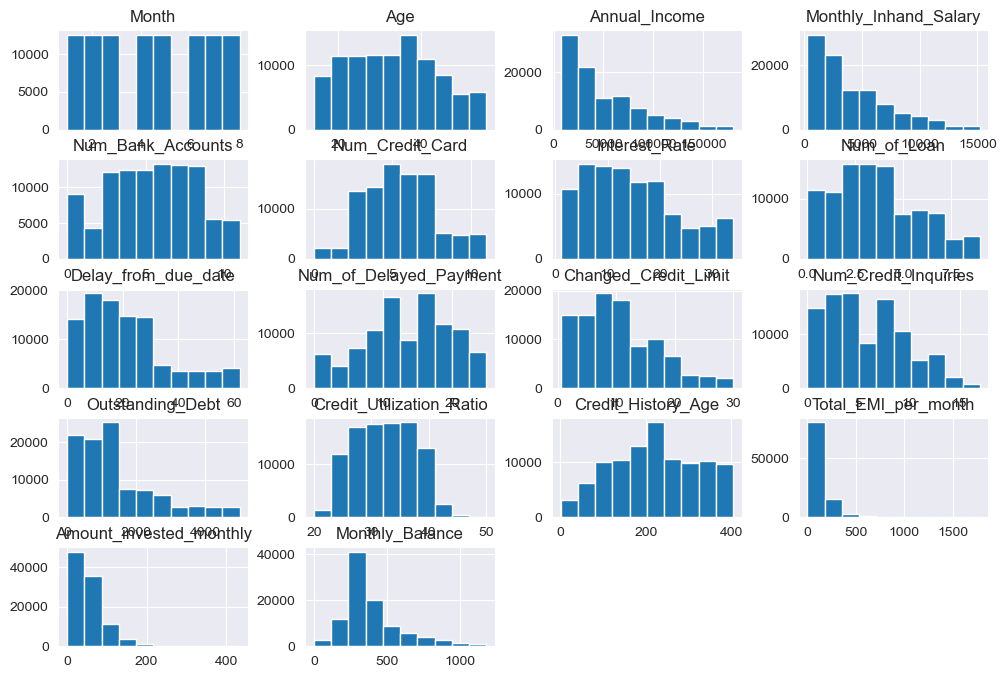

In [9]:
df.hist(figsize=(12,8))
plt.show()

Columns like "annual_income", "monthly_inhand_salary", "Delay_from_due_date", "Changed_Credit_Limit", "Outstanding_Debt", "Monthly_Balance" and  "Amount_invested_monthly" represent right skewness - a situation when mean is greater than median. Later we will need to deal with this.

<Figure size 2400x1600 with 0 Axes>

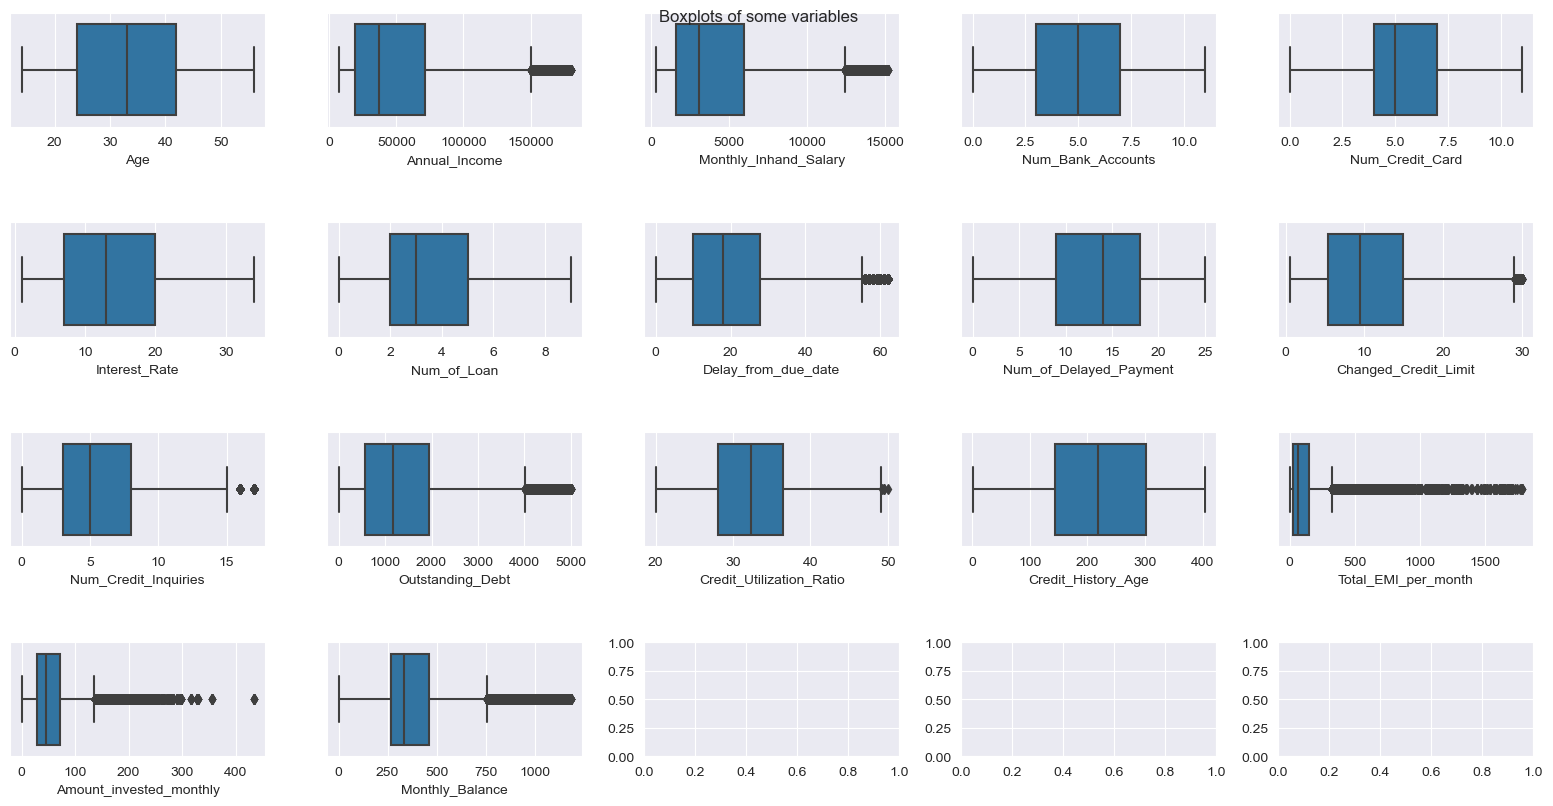

In [10]:
plt.figure(figsize=(24, 16))
fig, ax =plt.subplots(4,5, figsize=(16,8))
fig.tight_layout(h_pad=5)
fig.suptitle('Boxplots of some variables')
sns.boxplot(df, x="Age", ax=ax[0,0])
sns.boxplot(df, x="Annual_Income", ax=ax[0,1])
sns.boxplot(df, x="Monthly_Inhand_Salary", ax=ax[0,2])
sns.boxplot(df, x="Num_Bank_Accounts", ax=ax[0,3])
sns.boxplot(df, x="Num_Credit_Card", ax=ax[0,4])
sns.boxplot(df, x="Interest_Rate", ax=ax[1,0])
sns.boxplot(df, x="Num_of_Loan", ax=ax[1,1])
sns.boxplot(df, x="Delay_from_due_date", ax=ax[1,2])
sns.boxplot(df, x="Num_of_Delayed_Payment", ax=ax[1,3])
sns.boxplot(df, x="Changed_Credit_Limit", ax=ax[1,4])
sns.boxplot(df, x = "Num_Credit_Inquiries", ax=ax[2,0])
sns.boxplot(df, x="Outstanding_Debt", ax=ax[2,1])
sns.boxplot(df, x="Credit_Utilization_Ratio", ax=ax[2,2])
sns.boxplot(df, x="Credit_History_Age", ax=ax[2,3])
sns.boxplot(df, x="Total_EMI_per_month", ax=ax[2,4])
sns.boxplot(df, x="Amount_invested_monthly", ax=ax[3,0])
sns.boxplot(df, x="Monthly_Balance", ax=ax[3,1])

plt.show()

## EDA

In this part we will examine some relationship between variables to find out even more about clients.

Text(0.5, 1.0, 'Box plot of ages vs number of loans')

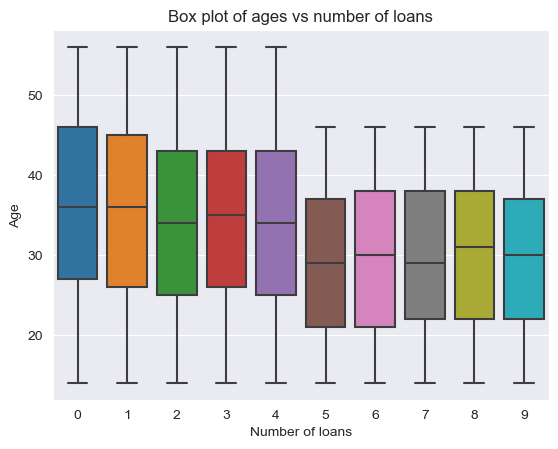

In [14]:
sns.boxplot(df, x='Num_of_Loan', y="Age")
plt.xlabel("Number of loans")
plt.title("Box plot of ages vs number of loans")

As you can see the older clients are the less loans they have. When it comes to over 5 loans per client this persons are usually around 30 years.

Text(0.5, 1.0, 'Box plots of annual income versus interest rate')

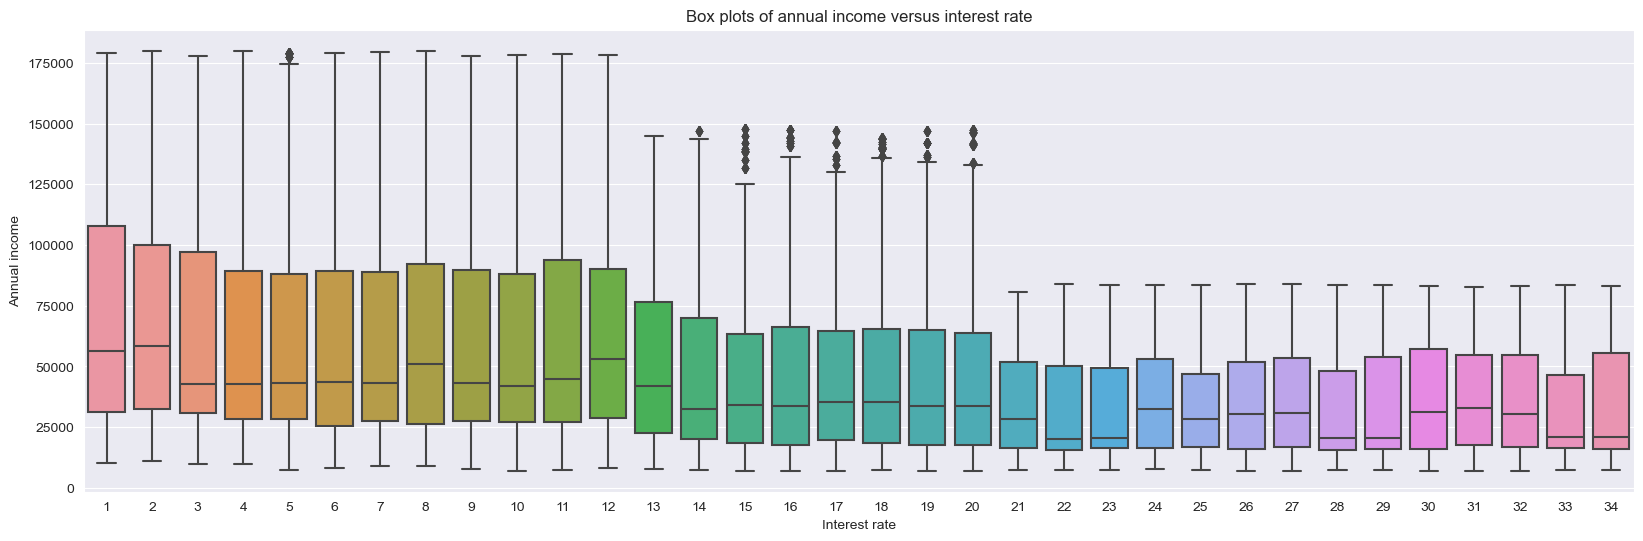

In [15]:
plt.figure(figsize=(20,6))
sns.boxplot(df, x='Interest_Rate', y="Annual_Income")
plt.xlabel("Interest rate")
plt.ylabel("Annual income")
plt.title("Box plots of annual income versus interest rate")

The interpretation here is simple. The more client is earning the lower interest rate he has. We can say that most rich persons credits with up to 12 % interest rate, middle lass between 13 and 20 % and the poorest has interest rate above 21%.

Text(0.5, 1.0, 'Box plots of monthly balance versus interest rate')

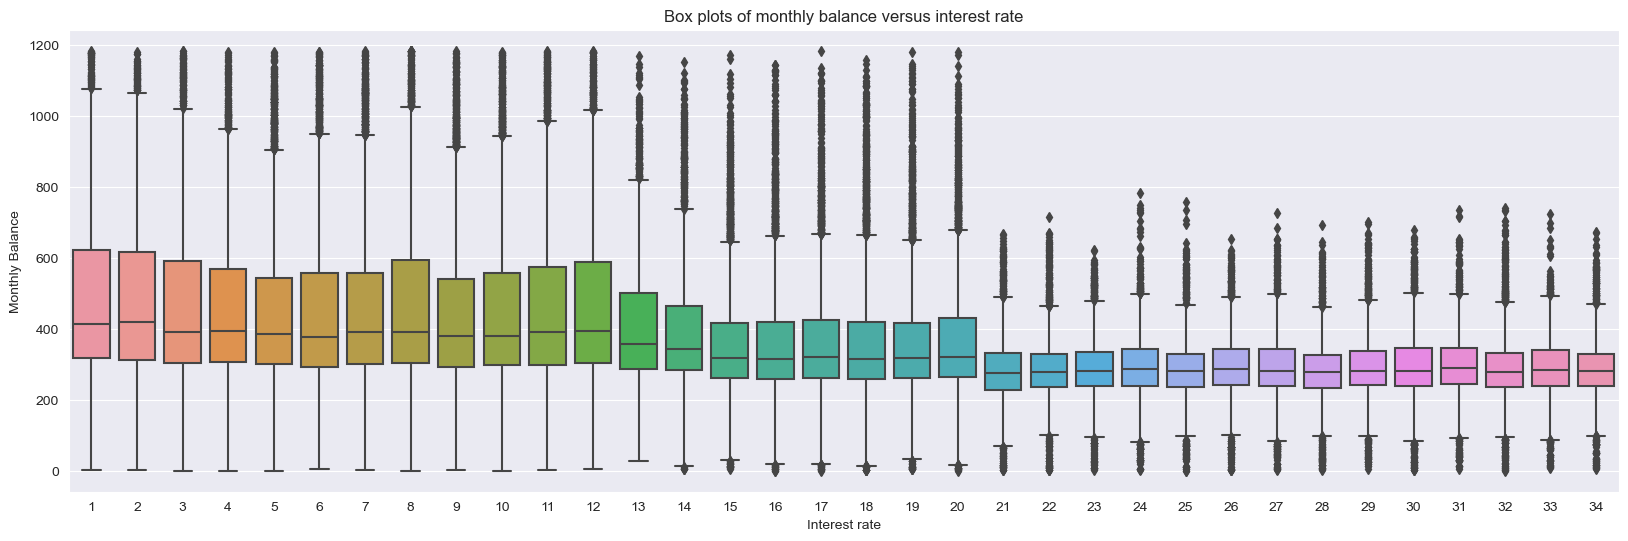

In [16]:
plt.figure(figsize=(20,6))
sns.boxplot(df, x='Interest_Rate', y="Monthly_Balance")
plt.xlabel("Interest rate")
plt.ylabel("Monthly Balance")
plt.title("Box plots of monthly balance versus interest rate")

We can say that clients with interest rate below 20% will have on average higher monthly balance comparing to clients with higher interest rate.

Text(0.5, 1.0, 'Scatter plot of annual income versus credit utilization ratio')

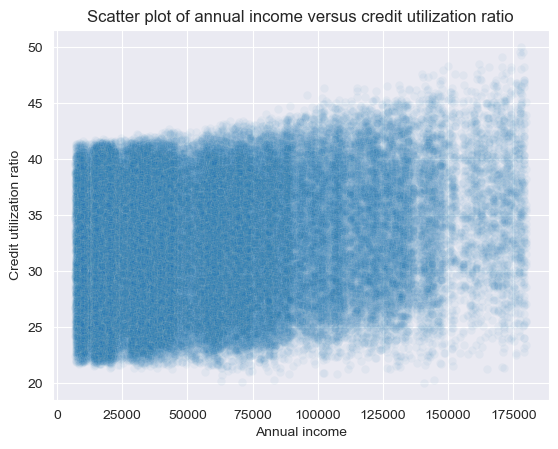

In [17]:
sns.scatterplot(df, x = "Annual_Income", y="Credit_Utilization_Ratio", alpha = 0.05)
plt.xlabel("Annual income")
plt.ylabel("Credit utilization ratio")
plt.title("Scatter plot of annual income versus credit utilization ratio")

Are this two features correlated? Let's check it.

Text(0.5, 1.0, 'Scatter plot of annual income versus credit utilization ratio with linear regression line')

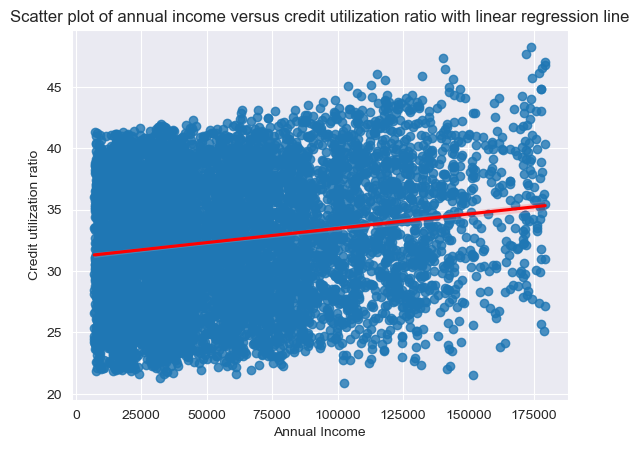

In [18]:
perc = 0.1
df_sub = df.sample(n = int(df.shape[0]*perc))

sns.regplot(x = "Annual_Income", y = "Credit_Utilization_Ratio", data = df_sub, line_kws={'color': 'red'}, lowess=False)
plt.xlabel("Annual Income")
plt.ylabel("Credit utilization ratio")
plt.title("Scatter plot of annual income versus credit utilization ratio with linear regression line")

These two features are positively correlated what means that the more clients earns the more he's using of his credit. The red line is representing linear regression line.

Text(0.5, 1.0, 'Scatter plot of annual income versus amount invested monthly')

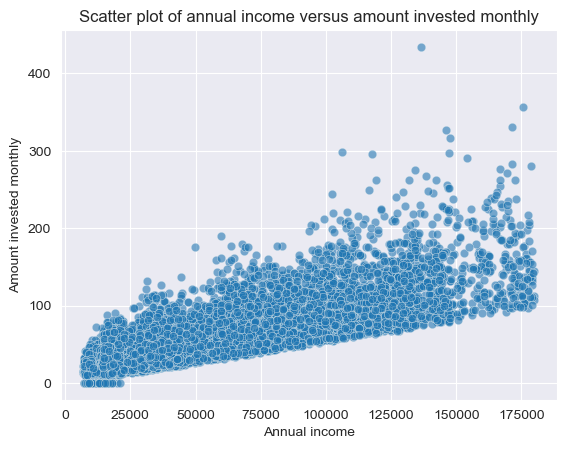

In [19]:
sns.scatterplot(df, x = "Annual_Income", y="Amount_invested_monthly", alpha=0.1)
plt.xlabel("Annual income")
plt.ylabel("Amount invested monthly")
plt.title("Scatter plot of annual income versus amount invested monthly")

Seems like Annual income and amount invested monthly are even more correlated whan predecessors. Investments are strictly correlated with clients' income.

## Feature Engineering

First column that requires some engineering is "Type_of_Loan". As you can see it represents types of loans client has. We want to separate each type into new variable.

Let's examine how many different types of loans clients have.

In [20]:
types_of_loan = df.Type_of_Loan.str.split(",")
all_loan_types = set()
for type in types_of_loan:
    for i in range(len(type)):
        all_loan_types.add(type[i])
print(all_loan_types)

{'credit-builder loan', 'student loan', 'mortgage loan', 'auto loan', 'payday loan', 'No Data', 'home equity loan', 'not specified', 'debt consolidation loan', 'personal loan'}


Many missing values has been hidden here under "Not specified" and "No Data" values. The idea here is as follows: if all types of loan are missing like "Not specified" or "No Data" we will set specified loan type column as 0. Otherwise we will give 1 end get dummies for each type of loan.

In [21]:
df["specified loan type"] = ""
types_of_loans_colnames = ['auto loan', 'credit-builder loan', 'personal loan', 'home equity loan', 'mortgage loan', 'student loan', 'debt consolidation loan', 'payday loan']
for type in types_of_loans_colnames:
    df[type] = ""

In [22]:
for count, row in enumerate(types_of_loan):
    if not any(loan in types_of_loans_colnames for loan in row) :
        df.loc[count, "specified loan type"] = 0
        for type in types_of_loans_colnames:
            df.loc[count, type] = 0
    else:
        df.loc[count, "specified loan type"] = 1
        present_types = set()
        for type in row:
            if (type != "not specified") and (type!= "No Data"):
                df.loc[count, type] = 1
                present_types.add(type)
        no_present_types = set(types_of_loans_colnames).difference(present_types)
        for type in list(no_present_types):
            df.loc[count, type] = 0

Finally we will drop loan type column.

In [23]:
df.drop(columns=["Type_of_Loan"], inplace=True)

Remember to set adequate data types for just created columns.

In [24]:
for col in ['auto loan', 'credit-builder loan', 'personal loan', 'home equity loan', 'mortgage loan', 'student loan', 'debt consolidation loan', 'payday loan', 'specified loan type']:
    df[col] = df[col].astype("int")

Another  column is credit mix.

Since variables here have order we will encode them from the worst to the best.

In [25]:
df.Credit_Mix = df.Credit_Mix.map({"Bad" : 0, "Standard" : 1, "Good" : 2})

In "Payment_of_Min-Amount" column we have some strange observations called "NM". I suppose that they mean "No" so we will change them and encode properly.

In [26]:
df['Payment_of_Min_Amount'].replace("NM","No",inplace=True)

In [27]:
df.Payment_of_Min_Amount = df.Payment_of_Min_Amount.map({"No" : 0, "Yes" : 1})

Payment Behaviour is another column where multiple features are hidden. Let's extract spent score and value size payments into new columns.

In [28]:
df.Payment_Behaviour.unique()

array(['High_spent_Small_value_payments',
       'Low_spent_Large_value_payments',
       'Low_spent_Medium_value_payments',
       'Low_spent_Small_value_payments',
       'High_spent_Medium_value_payments',
       'High_spent_Large_value_payments'], dtype=object)

In [29]:
types_of_payment_beh = list(df.Payment_Behaviour.str.split("_"))

In [30]:
df["spent type"] = [x[0] for x in types_of_payment_beh]
df["pay type"] = [x[2] for x in types_of_payment_beh]

Don't forget to encode them.

In [31]:
df["spent type"] = df["spent type"].map({"Low" : 0, "High" : 1})
df["pay type"] = df["pay type"].map({"Small" : 0, "Medium" : 1, "Large" : 2})

In [32]:
df.drop(columns = ["Payment_Behaviour"], inplace=True)

It's time to encode our target - Credit_Score.

In [33]:
df.Credit_Score = df.Credit_Score.map({"Poor" : 0, "Standard" : 1, "Good" : 2})

At the end of this part we will deal with last character column - Occupation. Since there's no order between any occupation (no one is better or worse) we will get dummies of each occupation.

In [34]:
df = pd.get_dummies(df,drop_first=True, dtype=np.int64)

## Correlation

Examining correlation especially in sets with a lot of features is very important step. If we find highly correlated features we can drop them to reduce dimensionality and speed up learning process.

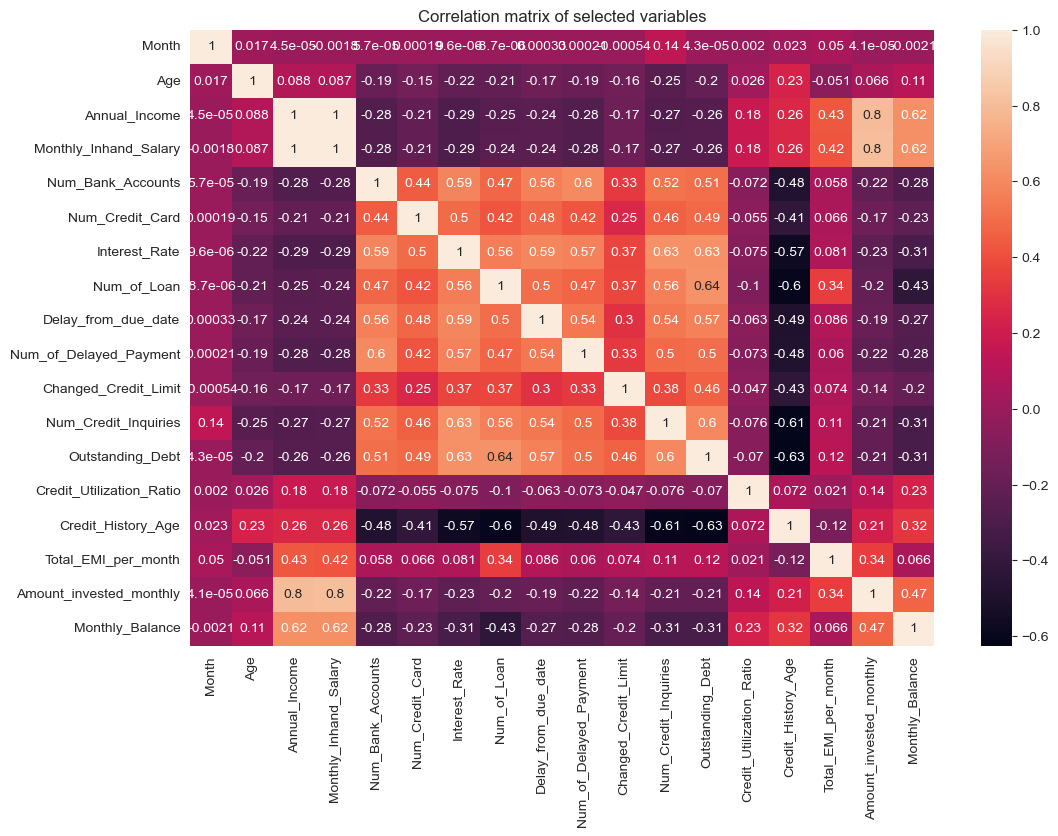

In [35]:
corr_matrix = df[["Month", "Age", "Annual_Income", "Monthly_Inhand_Salary", "Num_Bank_Accounts", "Num_Credit_Card", "Interest_Rate", "Num_of_Loan", "Delay_from_due_date", "Num_of_Delayed_Payment", "Changed_Credit_Limit", "Num_Credit_Inquiries", "Outstanding_Debt", "Credit_Utilization_Ratio", "Credit_History_Age", "Total_EMI_per_month", "Amount_invested_monthly", "Monthly_Balance"]].corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True)
plt.title("Correlation matrix of selected variables")
plt.show()

"Monthly_Inhand_Salary" is highly correlated with "Amount_invested_monthly" so we will drop one of them. The same situation with "Amount_invested_monthly" and "Annual_Income".

In [36]:
df.drop(columns = ["Monthly_Inhand_Salary", "Amount_invested_monthly"], inplace = True)

Another method to find features with highest importance to target is to use Information Gain which calculates the reduction in entropy from the transformation of a dataset.

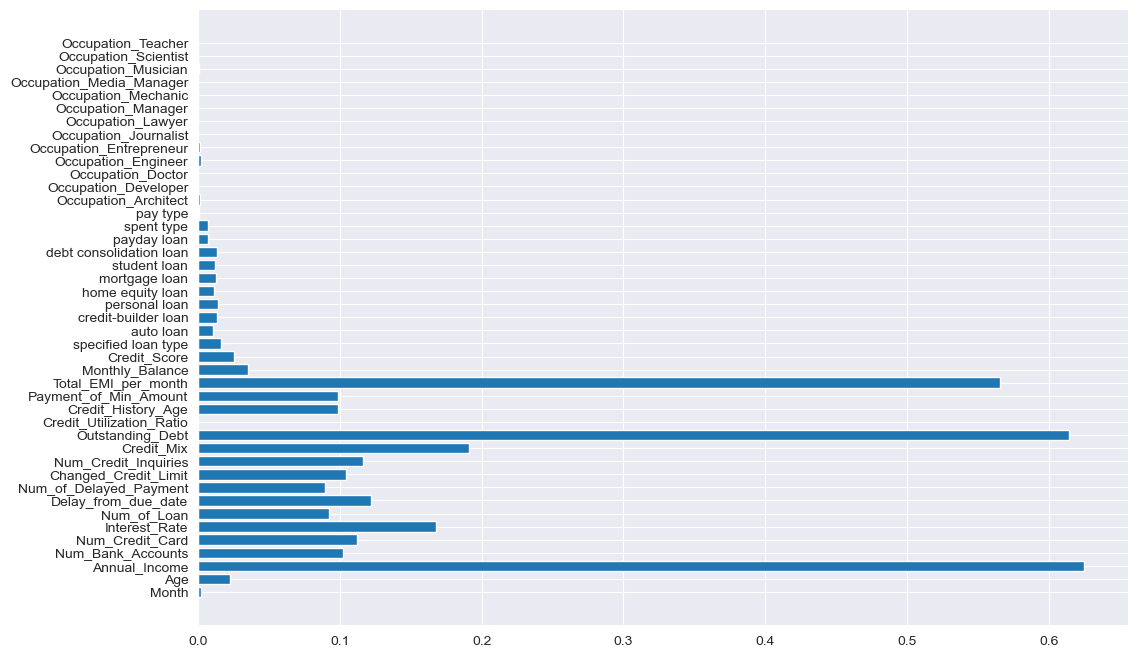

In [37]:
importances = mutual_info_classif(df.drop(columns = ["Credit_Score"]), df["Credit_Score"])
feature_importances = pd.Series(importances, df.columns[0:len(df.columns)-1])
plt.figure(figsize=(12,8))
plt.barh(df.columns[0:len(df.columns)-1], importances)
plt.show()

That's a huge discovery! Look how many column doesn't have impact on our credit score. Having this information we can reduce dimensionality of our dataset.

In [38]:
df.drop(columns = ["Month", "Credit_Utilization_Ratio", "Occupation_Architect", "Occupation_Developer", "Occupation_Doctor", "Occupation_Engineer", "Occupation_Entrepreneur", "Occupation_Journalist", "Occupation_Lawyer", "Occupation_Manager", "Occupation_Mechanic", "Occupation_Media_Manager", "Occupation_Musician", "Occupation_Scientist", "Occupation_Teacher", "Occupation_Writer"], inplace=True)

Important step in preparing data for classification is checking whether or not our values in target share the same percentage. If not there's a chance that your model will be biased.

In [39]:
df['Credit_Score'].value_counts(normalize=True)

1    0.533609
0    0.285903
2    0.180488
Name: Credit_Score, dtype: float64

Class with number "1" represent over a half of all instances. To make each class size equal we will use SMOTE. But first we will separate features from target.

In [40]:
X = df.drop(columns = ["Credit_Score"])
y = df["Credit_Score"]

In [41]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='auto')
X_smote, y_smote = smote.fit_resample(X, y)

It's time to split our data into train and test sets.

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.3, random_state=42,stratify=y_smote)

## Transformations

Some of the features distribution is right skewed. If we scale them right now we will use much information. To prevent this we will use PowerTransformer to make them look more like Gaussian distribution.

Last step is scaling our dataset using MinMaxScaler. All the transformations are stored in ColumnTransformer class.

In [43]:
log_cols = ["Annual_Income", "Delay_from_due_date", "Changed_Credit_Limit", "Outstanding_Debt", "Monthly_Balance"]
rest_cols = ["Age", "Num_Bank_Accounts", "Num_Credit_Card", "Interest_Rate", "Num_of_Loan", "Num_of_Delayed_Payment", "Num_Credit_Inquiries", "Credit_Mix",  "Credit_History_Age", "Payment_of_Min_Amount", "Total_EMI_per_month", 'specified loan type', 'auto loan', 'credit-builder loan', 'personal loan', 'home equity loan','mortgage loan', 'student loan', 'debt consolidation loan', 'payday loan', 'spent type', 'pay type']

log_pipeline = make_pipeline(PowerTransformer(standardize=False),MinMaxScaler())
rest_pipeline = make_pipeline(MinMaxScaler())

preprocessing = ColumnTransformer([("log", log_pipeline, log_cols), ("rest", rest_pipeline, rest_cols)])

In [44]:
X_train = preprocessing.fit_transform(X_train)
X_test = preprocessing.transform(X_test)

In [45]:
X_train = pd.DataFrame(X_train, columns = preprocessing.feature_names_in_)
X_test = pd.DataFrame(X_test, columns = preprocessing.feature_names_in_)

## Models implementation

To complete this task we will use models listed in the list below. We will evaluate each model, perform cross validation and save the classification report.

In [46]:
models = [LogisticRegression(multi_class="multinomial", solver="saga"), KNeighborsClassifier(), DecisionTreeClassifier(), RandomForestClassifier(), ExtraTreesClassifier(), HistGradientBoostingClassifier(), LGBMClassifier(), CatBoostClassifier(verbose=False), XGBClassifier()]
def result_reporter(classificator):
    model = classificator
    model.fit(X_train, y_train)
    y_train_pred = cross_val_predict(model, X_train, y_train, cv=3)
    result = classification_report(y_train, y_train_pred)
    return result

In [47]:
results = []
for model in models:
    results.append(result_reporter(model))

Let's see the results.

In [48]:
for result in results:
    print(result)
    print("-----------------------------------------------------")

              precision    recall  f1-score   support

           0       0.73      0.68      0.71     36759
           1       0.68      0.57      0.62     36759
           2       0.69      0.86      0.77     36759

    accuracy                           0.70    110277
   macro avg       0.70      0.70      0.70    110277
weighted avg       0.70      0.70      0.70    110277

-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.75      0.80      0.78     36759
           1       0.73      0.62      0.67     36759
           2       0.79      0.85      0.82     36759

    accuracy                           0.76    110277
   macro avg       0.75      0.76      0.75    110277
weighted avg       0.75      0.76      0.75    110277

-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.79      0.81      0.80     36759
           1       0.

The best model turned out to be a RandomForestClassifier with accuracy equal 86 %.

## Feature Importance

Let's see using best currently model what features are most important in predicting credit score.

In [49]:
etc = RandomForestClassifier()
etc.fit(X_train, y_train)
sorted(zip(etc.feature_importances_,etc.feature_names_in_),reverse=True)

[(0.12181568535699114, 'Num_Credit_Card'),
 (0.08727917824090968, 'Credit_History_Age'),
 (0.08613249057615223, 'Changed_Credit_Limit'),
 (0.08145151670708933, 'Payment_of_Min_Amount'),
 (0.07011331939567088, 'Annual_Income'),
 (0.055693847665470954, 'Num_Bank_Accounts'),
 (0.055200640929161965, 'Interest_Rate'),
 (0.04866130005380241, 'Age'),
 (0.047375711816835635, 'Monthly_Balance'),
 (0.04633751194314056, 'Outstanding_Debt'),
 (0.044856593875181476, 'Credit_Mix'),
 (0.041000614479207546, 'Num_of_Loan'),
 (0.039315899246586114, 'Delay_from_due_date'),
 (0.039249171899121756, 'Num_of_Delayed_Payment'),
 (0.032114114941202636, 'Total_EMI_per_month'),
 (0.025342673214347005, 'Num_Credit_Inquiries'),
 (0.015433778445276556, 'pay type'),
 (0.009205373346784514, 'spent type'),
 (0.006442074815364919, 'student loan'),
 (0.006351626909505184, 'auto loan'),
 (0.006263116096233264, 'personal loan'),
 (0.006213728447279177, 'mortgage loan'),
 (0.006188758409365547, 'payday loan'),
 (0.00615663

Most important features are Number of credit cards, Credit history, Changed credit limit, Payment of Min Amount and Annual Income.

## Hyperparameter Tuning

This part is dedicated to tuning best models' hyperparameters. Because the set is large whole process will take a few hours. It you want to do it anyway simply unhash code below.

In [50]:
# best_models = [RandomForestClassifier(), ExtraTreesClassifier(), XGBClassifier()]

In [51]:
# models_hyperparameters = [[RandomForestClassifier(), { 'criterion' : ['gini', 'entropy', 'log_loss'], 'n_estimators': [ 50, 100, 150], 'max_features': ['sqrt', 'log2', None]}], [ExtraTreesClassifier(), { 'criterion' : ['gini', 'entropy', 'log_loss'], 'n_estimators': [ 50, 100, 150], 'max_features': ['sqrt', 'log2', None] }], [XGBClassifier(), {'learning_rate' : [0.001, 0.01, 0.05, 0.1], 'n_estimators': [100, 200, 300], 'subsample': [0.8, 1.0], 'colsample_bytree': [0.8, 1.0], 'max_depth' : [3,4,5]}]]

In [52]:
# grid_results = []
# for model in models_hyperparameters:
#     grid = GridSearchCV(model[0], model[1], cv=3, scoring = 'accuracy')
#     grid.fit(X_train, y_train)
#     grid_results.append(pd.DataFrame(grid.cv_results_))

In [53]:
# for result in grid_results:
#     print(result)

## Neural Network

It's time to use Deep Learning methods. Can we improve current score?

In [56]:
y_train_tf = tensorflow.keras.utils.to_categorical(y_train, dtype = 'int64')
y_test_tf = tensorflow.keras.utils.to_categorical(y_test, dtype = 'int64')

In [81]:
def design_model(features):
    model = Sequential(name = "Neural_Network")
    input = InputLayer(input_shape=(X_train.shape[1],))
    model.add(input)
    model.add(Dense(64, activation = "relu"))
    model.add(Dense(128, activation = "relu"))
    model.add(Dense(64, activation = "relu"))
    model.add(Dense(32, activation = "relu"))
    model.add(Dense(256, activation = "relu"))
    model.add(Dense(3, activation = "softmax"))
    opt = Adam(learning_rate = 0.01)
    model.compile(loss = "categorical_crossentropy", metrics = ["accuracy"], optimizer = opt)
    return model

model = design_model(X_train)
es = EarlyStopping(monitor='accuracy', mode='min', verbose=1, patience=8)
model.summary()

Model: "Neural_Network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_57 (Dense)            (None, 64)                1792      
                                                                 
 dense_58 (Dense)            (None, 128)               8320      
                                                                 
 dense_59 (Dense)            (None, 64)                8256      
                                                                 
 dense_60 (Dense)            (None, 32)                2080      
                                                                 
 dense_61 (Dense)            (None, 256)               8448      
                                                                 
 dense_62 (Dense)            (None, 3)                 771       
                                                                 
Total params: 29667 (115.89 KB)
Trainable params: 29

In [82]:
history = model.fit(X_train, y_train_tf, epochs = 10, batch_size = 32, verbose = 1, callbacks = [es])

Epoch 1/10
3447/3447 [==============================] - 23s 5ms/step - loss: 0.7517 - accuracy: 0.7059
Epoch 2/10
3447/3447 [==============================] - 16s 5ms/step - loss: 0.7233 - accuracy: 0.7189
Epoch 3/10
3447/3447 [==============================] - 16s 5ms/step - loss: 0.7168 - accuracy: 0.7206
Epoch 4/10
3447/3447 [==============================] - 16s 5ms/step - loss: 0.7138 - accuracy: 0.7222
Epoch 5/10
3447/3447 [==============================] - 17s 5ms/step - loss: 0.7128 - accuracy: 0.7217
Epoch 6/10
3447/3447 [==============================] - 16s 5ms/step - loss: 0.7111 - accuracy: 0.7229
Epoch 7/10
3447/3447 [==============================] - 15s 4ms/step - loss: 0.7078 - accuracy: 0.7249
Epoch 8/10
3447/3447 [==============================] - 14s 4ms/step - loss: 0.7055 - accuracy: 0.7243
Epoch 9/10
3447/3447 [==============================] - 15s 4ms/step - loss: 0.7047 - accuracy: 0.7252
Epoch 9: early stopping


## Evaluation on test set

Since neural network achieved hasn't achieved better results our final model is RandomForestClassifier. Now let's evaluate them on the test set.

In [83]:
final_model = RandomForestClassifier()
final_model.fit(X_train, y_train)
print(classification_report(y_test, final_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90     15754
           1       0.87      0.78      0.82     15754
           2       0.89      0.94      0.91     15754

    accuracy                           0.88     47262
   macro avg       0.88      0.88      0.88     47262
weighted avg       0.88      0.88      0.88     47262


This is how the confusion matrix look like.

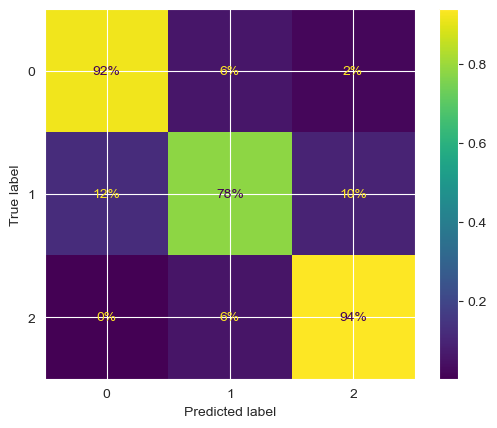

In [84]:
ConfusionMatrixDisplay.from_predictions(y_test, final_model.predict(X_test), normalize="true", values_format=".0%")
plt.show()

The results are pretty good and are better than on the train set.

## Model save

In the end we will save our model.

In [86]:
best_model_save = "credit_score_model.pkl"

Our job is done.